In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

### We want to find out if the popularity of the actors of a tv serie has an impact on the rating of the serie.

##### First we read in all the data we need.

In [2]:
ratings_dtype = {
    'tconst': str,
    'averageRating': float,
    'numVotes': int
}

ratings = pd.read_csv('./title.ratings.tsv.gz', sep='\t', header=0, dtype=ratings_dtype)

principals_dtype = {
    'tconst': str,
    'principalCast': object
}

principals = pd.read_csv('./title.principals.tsv.gz', sep='\t', header=0, dtype=principals_dtype)

basics_dtype = {
    'tconst': str,
    'titleType': str,
    'primaryTitle': str,
    'originalTitle': str,
    'isAdult': int,
    'startYear': str,
    'endYear': str,
    'runtimeMinutes': object,
    'genres': str
}

basics = pd.read_csv('./title.basics.tsv.gz', sep='\t', header=0, dtype=basics_dtype)

###### The dataset "rating" contains a string for the title of the tv serie, the average rating and the number of votes. The dataset "principal" also contains the string for the title of the tv serie and a principalCast object, wich contains a string for each crew member, wich category he or she belongs to (for example director, cinematographer, composer, actor etc.), the job, the character he or she is playing and an ordering for the payment. Unfortunately we don't know how well they are payed, only the ordering. 
###### The "basics" dataset contains among other things the titleType like "short", "movie" or "tvSeries", wich we need to filter out the series.
##### In the next step we delete the columns and rows we don't need and merge the datasets to one.

In [3]:
ratings = ratings[['tconst', 'averageRating']]

actors = principals[principals['category'] == 'actor']
actors =  actors[['tconst', 'ordering', 'nconst']]

series  =  basics[basics['titleType'] == 'tvSeries']
series = series[['tconst']]

In [64]:
data = pd.merge(series, pd.merge(ratings, actors), how='inner')

In [65]:
data.head()

,tconst,averageRating,ordering,nconst
0,tt0039120,3.7,3,nm0240118
1,tt0039120,3.7,4,nm0416564
2,tt0039123,8.5,10,nm0453006
3,tt0039123,8.5,1,nm0853299
4,tt0039123,8.5,4,nm0550855


##### In order to sort the actors according to popularity, we count the number of the series in wich the actor takes place. We call this information "popularity" and add it to our dataset. Also we calculate the average rating of all series in wich the actor takes play and call it "seriesAverageRating".

In [66]:
data['popularity'] = pd.Series(np.zeros(data.shape[0]))
data['seriesAverageRating'] = pd.Series(np.zeros(data.shape[0]))

In [67]:
actorsDict = data['nconst'].value_counts().to_dict()

sumAverageRatingDict = {}

data = data.sort_values(by=['nconst'])

In [68]:
# iterate over dataframe "data" and fill dictionary "sumAverageRatingDict" with sum of average rating of series with this actor
for i, line in data.iterrows():
    value = line['nconst']
    if value in sumAverageRatingDict:
        rating = sumAverageRatingDict[value]
        sumAverageRatingDict[value] = rating + line['averageRating']
    else:
        sumAverageRatingDict[value] = line['averageRating']

In [69]:
# fill the new columns of the dataset
def fillDataset(data, actorsDict, ratingDict):
    for i, line in data.iterrows():
        value = line['nconst']
        data.set_value(i, 'popularity', actorsDict[value])
        ave = ratingDict[value] / actorsDict[value]
        data.set_value(i, 'seriesAverageRating', ave)

In [71]:
fillDataset(data, actorsDict, sumAverageRatingDict)

##### Now we plot the new columns "seriesAverageRating" and "seriesCount" to see if in average series are better rated, when the actors are more popular.

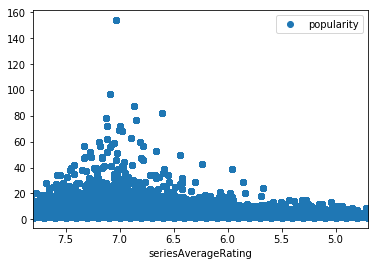

In [72]:
data.plot(x='seriesAverageRating', y='popularity', style='o')

##### We can see a tendency, maybe it gets clearer when we also consider the payment order of the actors, since more popular actors get better payed.

##### For that we only consider the top three actors of a serie regarding the payment and weight the rating of the serie according to the payment order.

In [73]:
data = data.sort_values(by=['tconst', 'ordering'])

In [74]:
serie = 'tt0000000'
counter = 3
indexList = list()
for i, line in data.iterrows():
    nextSerie = line['tconst']
    if nextSerie > serie:
        serie = nextSerie
        counter = 2
    elif nextSerie == serie and counter == 0:
        indexList.append(i)
    else:
        counter = counter - 1

In [75]:
indexList = sorted(indexList, reverse=True)

In [78]:
# droping the rows takes a lot of time
for i in indexList:
    data = data.drop(data.index[i])

In [79]:
data.head(10)

,tconst,averageRating,ordering,nconst,popularity,seriesAverageRating
0,tt0039120,3.7,3,nm0240118,1.0,3.700000
1,tt0039120,3.7,4,nm0416564,2.0,5.550000
4,tt0039123,8.5,4,nm0550855,12.0,7.575000
5,tt0039123,8.5,5,nm0870038,6.0,7.866667
6,tt0039123,8.5,6,nm0549557,5.0,7.340000
9,tt0039125,5.9,1,nm0397397,4.0,6.425000
10,tt0039125,5.9,3,nm0761340,5.0,7.320000
11,tt0039125,5.9,4,nm0363515,4.0,7.100000
17,tt0040021,7.1,3,nm0358449,4.0,7.000000
18,tt0040021,7.1,5,nm0838057,3.0,7.800000


In [83]:
actorsWeightedRating = {}

serie = 'tt0000000'
counter = 0
for i, line in data.iterrows():
    nextSerie = line['tconst']
    actor = line['nconst']
    if nextSerie > serie:
        serie = nextSerie
        counter = 3
    else:
        counter = counter - 1
    
    if actor in actorsWeightedRating:
        actorsWeightedRating[actor] = actorsWeightedRating[actor] + line['averageRating'] * counter
    else:
        actorsWeightedRating[actor] = line['averageRating'] * counter

In [84]:
actorsDict = data['nconst'].value_counts().to_dict()
fillDataset(data, actorsDict, actorsWeightedRating)

In [85]:
data.head(10)

,tconst,averageRating,ordering,nconst,popularity,seriesAverageRating
0,tt0039120,3.7,3,nm0240118,1.0,11.100000
1,tt0039120,3.7,4,nm0416564,2.0,7.400000
4,tt0039123,8.5,4,nm0550855,7.0,17.100000
5,tt0039123,8.5,5,nm0870038,4.0,19.350000
6,tt0039123,8.5,6,nm0549557,2.0,8.500000
9,tt0039125,5.9,1,nm0397397,3.0,15.833333
10,tt0039125,5.9,3,nm0761340,1.0,11.800000
11,tt0039125,5.9,4,nm0363515,3.0,7.000000
17,tt0040021,7.1,3,nm0358449,1.0,21.300000
18,tt0040021,7.1,5,nm0838057,2.0,15.600000


##### Now let's see if the relation gets clearer.

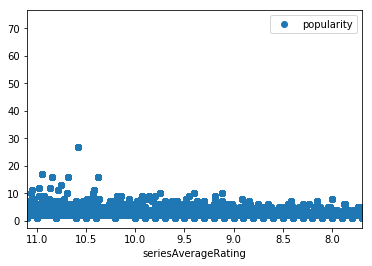

In [86]:
data.plot(x='seriesAverageRating', y='popularity', style='o')

##### We have a tendency again, but the correlation between popularity and rating seems not  stronger than before. Unfortunately we don't have an actual popularity measure in this dataset, like payment or a actors rating.